# Task 4: Commenter Networks

## Objectives
1. Build commenter-commenter interaction graph
2. Calculate PageRank for commenters
3. Identify top-10 influencers by time period
4. **Enhanced Analysis**: Community Detection & Ego Graphs
5. Deliverable: Influencer ranking visualization

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import glob
import os
import random
from datetime import datetime, timedelta
import numpy as np
import community as community_louvain # python-louvain

## 1. Load Data

We will load the comment data from the `DriveData` directory.
We optimize memory usage by reading only necessary columns.

In [2]:
# Configuration
DATA_DIR = '../DriveData/'
USE_DUMMY_DATA_IF_MISSING = True

def load_data(data_dir):
    all_files = glob.glob(os.path.join(data_dir, "*.csv"))
    
    if not all_files:
        print(f"No CSV files found in {data_dir}")
        return None
    
    df_list = []
    for filename in all_files:
        try:
            # Read only necessary columns to save memory if files are huge
            usecols = ['comment_id', 'parent_id', 'author_channel_id', 'author_name', 'published_at']
            df = pd.read_csv(filename, usecols=usecols)
            df_list.append(df)
            print(f"Loaded {filename}: {len(df)} rows")
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            
    if not df_list:
        return None
        
    return pd.concat(df_list, ignore_index=True)

def generate_dummy_data(num_comments=1000):
    print("Generating dummy data for verification...")
    
    # Generate some users
    users = [f"User_{i}" for i in range(100)]
    channel_ids = [f"UC_{i}" for i in range(100)]
    user_map = dict(zip(users, channel_ids))
    
    data = []
    start_date = datetime(2023, 1, 1)
    
    # Create some top-level comments
    top_level_ids = []
    for i in range(num_comments // 2):
        user = random.choice(users)
        comment_id = f"c_{i}"
        top_level_ids.append(comment_id)
        
        data.append({
            'video_id': 'v_1',
            'comment_id': comment_id,
            'parent_id': None, # Top level
            'comment_text': 'Great video!',
            'author_name': user,
            'author_channel_id': user_map[user],
            'published_at': (start_date + timedelta(days=random.randint(0, 365))).isoformat() + 'Z',
            'like_count': random.randint(0, 100)
        })
        
    # Create replies
    for i in range(num_comments // 2, num_comments):
        user = random.choice(users)
        comment_id = f"c_{i}"
        parent_id = random.choice(top_level_ids)
        
        data.append({
            'video_id': 'v_1',
            'comment_id': comment_id,
            'parent_id': parent_id,
            'comment_text': 'I agree!',
            'author_name': user,
            'author_channel_id': user_map[user],
            'published_at': (start_date + timedelta(days=random.randint(0, 365))).isoformat() + 'Z',
            'like_count': random.randint(0, 50)
        })
        
    return pd.DataFrame(data)

# Main loading logic
comments_df = load_data(DATA_DIR)

if comments_df is None and USE_DUMMY_DATA_IF_MISSING:
    comments_df = generate_dummy_data()
    print("Loaded dummy data.")
elif comments_df is not None:
    print(f"Loaded {len(comments_df)} comments from files.")
else:
    raise ValueError("No data found and dummy data generation disabled.")

# Preprocessing
comments_df['published_at'] = pd.to_datetime(comments_df['published_at'])
comments_df.head()

/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/1621337232.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=usecols)


Loaded ../DriveData/comment1.csv: 1413653 rows


/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/1621337232.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=usecols)


Loaded ../DriveData/comment2.csv: 832041 rows


/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/1621337232.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=usecols)


Loaded ../DriveData/comment3.csv: 1116331 rows


/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/1621337232.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=usecols)


Loaded ../DriveData/comment4.csv: 1539237 rows


/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/1621337232.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, usecols=usecols)


Loaded ../DriveData/comment5.csv: 1038920 rows


Loaded 5940182 comments from files.


,comment_id,parent_id,author_name,author_channel_id,published_at
0,UgxeYo0-MMQQHfg9Red4AaABAg.8wsZ2d33UJ-9WXoa6zVYes,UgxeYo0-MMQQHfg9Red4AaABAg,@GrahamWhatmough,UCJAbstgijk_gmkjV8mUv3dA,2021-12-29 12:48:13+00:00
1,Ugz_343-IxqQpxkPnql4AaABAg.9XchlzLgbjv9Xcka6bJV6z,Ugz_343-IxqQpxkPnql4AaABAg,@mariaangelicabrunellsolar7086,UCiClJzQdNQeAqcrfDXNbrxg,2022-01-25 16:40:06+00:00
2,Ugzv10b6wGEDtG6MTdt4AaABAg.9fHHgXtAqCn9fIYKmb6RzC,Ugzv10b6wGEDtG6MTdt4AaABAg,@cryjng549,UCw0SZln-5RMABfwH7uwy54A,2022-08-29 03:42:46+00:00
3,Ugxt9xZzkF5Jz8B0Exh4AaABAg.9_35Sa1lp_79_36FU9OvvM,Ugxt9xZzkF5Jz8B0Exh4AaABAg,@nuggets9113,UC4mbqL87SjY81CAbsI8zaow,2022-03-27 00:40:24+00:00
4,Ugx3a2fgbYkcd5Esl1x4AaABAg.9hhcVCVattK9hhfEpDn7hC,Ugx3a2fgbYkcd5Esl1x4AaABAg,@imcallingjapan2178,UC3EqH1tdXsQPVODMjeEUBUg,2022-10-28 00:14:54+00:00


## 2. Build Commenter-Commenter Interaction Graph

We define an interaction as User A replying to User B's comment.
- **Nodes**: Commenters (identified by `author_channel_id`)
- **Edges**: Directed edge from Replier -> Original Commenter (indicating attention/influence flow, or interaction)
  - *Note*: PageRank typically measures "importance". If A replies to B, A is paying attention to B. So a link A -> B increases B's score.

Steps:
1. Create a mapping of `comment_id` to `author_channel_id` (and `author_name` for display).
2. Identify replies (rows where `parent_id` is not null).
3. For each reply, find the author of the parent comment.
4. Create edges.

In [3]:
def build_interaction_graph(df):
    G = nx.DiGraph()
    
    # Map comment_id to author info
    # Note: We need to ensure we have the author for the parent_id.
    # If the parent comment is not in the dataset (e.g. filtered out or from a different file not loaded), we can't link it.
    comment_author_map = df.set_index('comment_id')['author_channel_id'].to_dict()
    author_name_map = df.groupby('author_channel_id')['author_name'].first().to_dict()
    
    # Filter for replies
    replies = df[df['parent_id'].notna()]
    
    edges = []
    for _, row in replies.iterrows():
        replier_id = row['author_channel_id']
        parent_id = row['parent_id']
        
        # Find original author
        if parent_id in comment_author_map:
            original_author_id = comment_author_map[parent_id]
            
            # Avoid self-loops if desired (optional, but usually good for influence)
            if replier_id != original_author_id:
                edges.append((replier_id, original_author_id))
    
    # Add edges with weights (count interactions)
    for u, v in edges:
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
            
    # Add node attributes
    # Only add names for nodes in the graph
    existing_nodes = set(G.nodes())
    filtered_names = {k: v for k, v in author_name_map.items() if k in existing_nodes}
    nx.set_node_attributes(G, filtered_names, 'name')
    
    return G

G_global = build_interaction_graph(comments_df)
print(f"Global Graph: {G_global.number_of_nodes()} nodes, {G_global.number_of_edges()} edges")

Global Graph: 848350 nodes, 748961 edges


## 3. Calculate PageRank

We calculate PageRank on the global graph to find overall influencers.

In [4]:
def calculate_pagerank(G):
    if len(G) == 0:
        return {}
    return nx.pagerank(G, weight='weight')

pagerank_scores = calculate_pagerank(G_global)

# Get top 10
top_10_global = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Global Influencers:")
for i, (uid, score) in enumerate(top_10_global, 1):
    name = G_global.nodes[uid].get('name', 'Unknown')
    print(f"{i}. {name} ({uid}): {score:.4f}")

Top 10 Global Influencers:
1. @cj6408 (UCXZpF2ymFVJ4zmEo7kPuUfQ): 0.0003
2. @user-hm9xg7xf6z (UC9-uyGny5WfuwKYSzUcCm1g): 0.0001
3. @ellysaj2785 (UC7sOvPsElABIv3O4Oh1ghaQ): 0.0001
4. @kontorrecords (UCb3tJ5NKw7mDxyaQ73mwbRg): 0.0001
5. @JustinY. (UCiTfB-A55Vq2fB610vaWJVA): 0.0001
6. Unknown (nan): 0.0000
7. @papayace (UCA9tK93NiAlVZ4aTugJEzGg): 0.0000
8. @quetzalrcoatl (UC9bMdcRdbT5Aouw8UtA43-g): 0.0000
9. @Burty_YT (UC8PVX24mu8kEbzw4Yov7yDw): 0.0000
10. @kalpitkumawat682 (UCk9z9JoZJPQzSa4t4WpCI_Q): 0.0000


## 4. Identify Top-10 Influencers by Time Period

We will split the data into time periods (e.g., Monthly) and calculate PageRank for each period to see how influence evolves.

In [5]:
# Group by Month
comments_df['period'] = comments_df['published_at'].dt.to_period('M')

periods = sorted(comments_df['period'].unique())
period_influencers = {}

print(f"Analyzing {len(periods)} periods...")

for period in periods:
    # Filter data for this period
    period_df = comments_df[comments_df['period'] == period]
    
    # Build graph
    G_period = build_interaction_graph(period_df)
    
    # Calculate PageRank
    scores = calculate_pagerank(G_period)
    
    # Get Top 10
    top_10 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Store results (store name and score)
    results = []
    for uid, score in top_10:
        name = G_period.nodes[uid].get('name', 'Unknown')
        results.append({'id': uid, 'name': name, 'score': score})
        
    period_influencers[str(period)] = results

# Display results for a few periods
for p in list(period_influencers.keys())[:3]: # Show first 3
    print(f"\nPeriod: {p}")
    for i, item in enumerate(period_influencers[p], 1):
        print(f"  {i}. {item['name']}: {item['score']:.4f}")

/var/folders/kv/4851x5y146b3tkg8dcffhlyw0000gn/T/ipykernel_45122/110592498.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  comments_df['period'] = comments_df['published_at'].dt.to_period('M')


Analyzing 210 periods...



Period: 2006-07

Period: 2006-08

Period: 2006-09


## 5. Enhanced Visualization & Analysis

### 5.1 Ego Graph Visualization
Instead of showing a disconnected top-50 graph, we show the **Ego Graph** of the top influencer. This shows the influencer and everyone who interacted with them, which guarantees a connected and meaningful graph.

Ego Graph for UCXZpF2ymFVJ4zmEo7kPuUfQ: 294 nodes, 293 edges


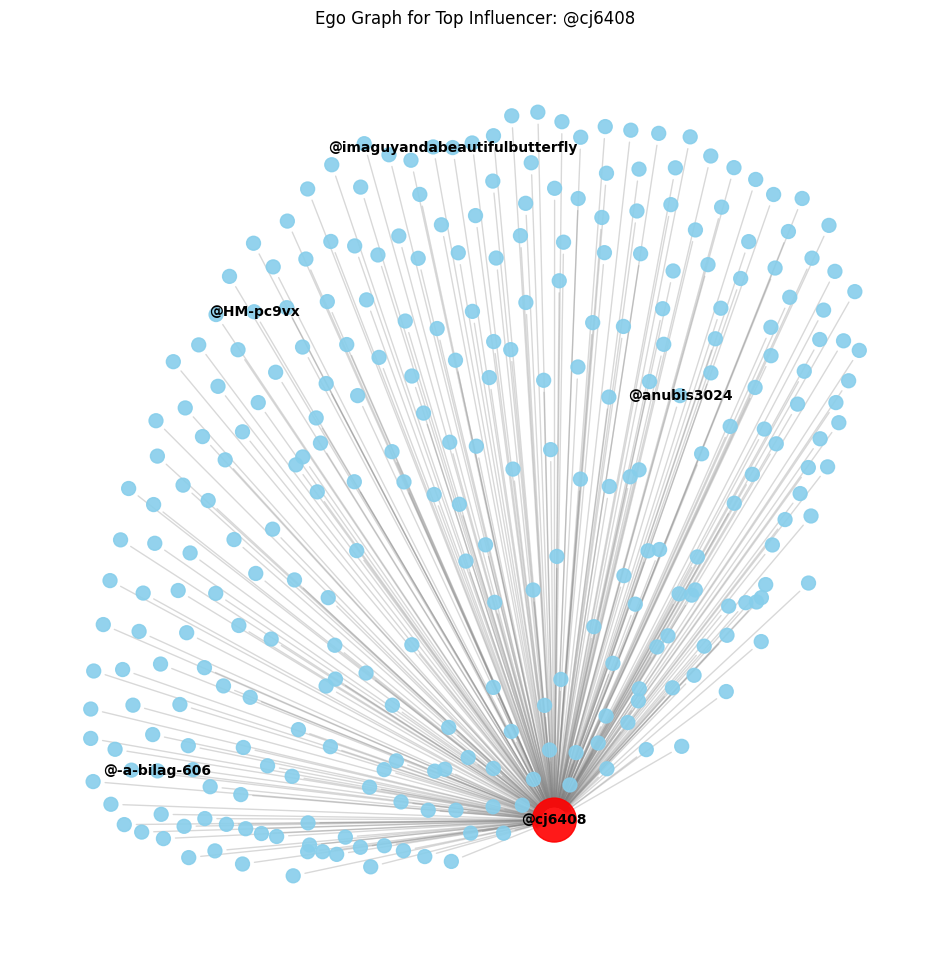

In [6]:
def plot_ego_graph(G, center_node, radius=1):
    if center_node not in G:
        print(f"Node {center_node} not found in graph.")
        return
        
    # Create Ego Graph (undirected to capture incoming edges/fans)
    # We want to see who replied to the influencer, so we look at the undirected version for the neighborhood
    G_undirected = G.to_undirected()
    ego_G_undirected = nx.ego_graph(G_undirected, center_node, radius=radius)
    
    # But we want to visualize the directions if possible, so we take the subgraph from the original DiGraph
    ego_G = G.subgraph(ego_G_undirected.nodes())
    
    print(f"Ego Graph for {center_node}: {len(ego_G)} nodes, {ego_G.number_of_edges()} edges")
    
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(ego_G, k=0.3, seed=42)
    
    # Draw nodes
    # Center node larger and red
    node_colors = ['red' if n == center_node else 'skyblue' for n in ego_G.nodes()]
    node_sizes = [1000 if n == center_node else 100 for n in ego_G.nodes()]
    
    nx.draw_networkx_nodes(ego_G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(ego_G, pos, edge_color='gray', alpha=0.3, arrows=True)
    
    # Labels for center and significant neighbors
    labels = {}
    labels[center_node] = G.nodes[center_node].get('name', 'Center')
    
    # Label top 5 neighbors by degree in this subgraph
    degrees = dict(ego_G.degree())
    top_neighbors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    for n, d in top_neighbors:
        if n != center_node:
            labels[n] = G.nodes[n].get('name', '')
    
    nx.draw_networkx_labels(ego_G, pos, labels=labels, font_size=10, font_weight='bold')
    
    center_name = G.nodes[center_node].get('name', center_node)
    plt.title(f'Ego Graph for Top Influencer: {center_name}')
    plt.axis('off')
    plt.show()

# Visualize Ego Graph for the #1 Global Influencer
if top_10_global:
    top_influencer_id = top_10_global[0][0]
    plot_ego_graph(G_global, top_influencer_id)

**Graph Explanation:**
This Ego Graph illustrates the immediate network of the top influencer. The central node represents the influencer, and the surrounding nodes are the commenters who have replied to them. This visualization helps in understanding the direct reach and engagement of the influencer.

### 5.2 Community Detection
We use the Louvain method to detect communities (groups of users who interact more frequently with each other). We then visualize the graph colored by community.

Detected 134365 communities.
Filtering graph for visualization (Top 1000 nodes by PageRank)...


Visualizing graph with 1000 nodes...


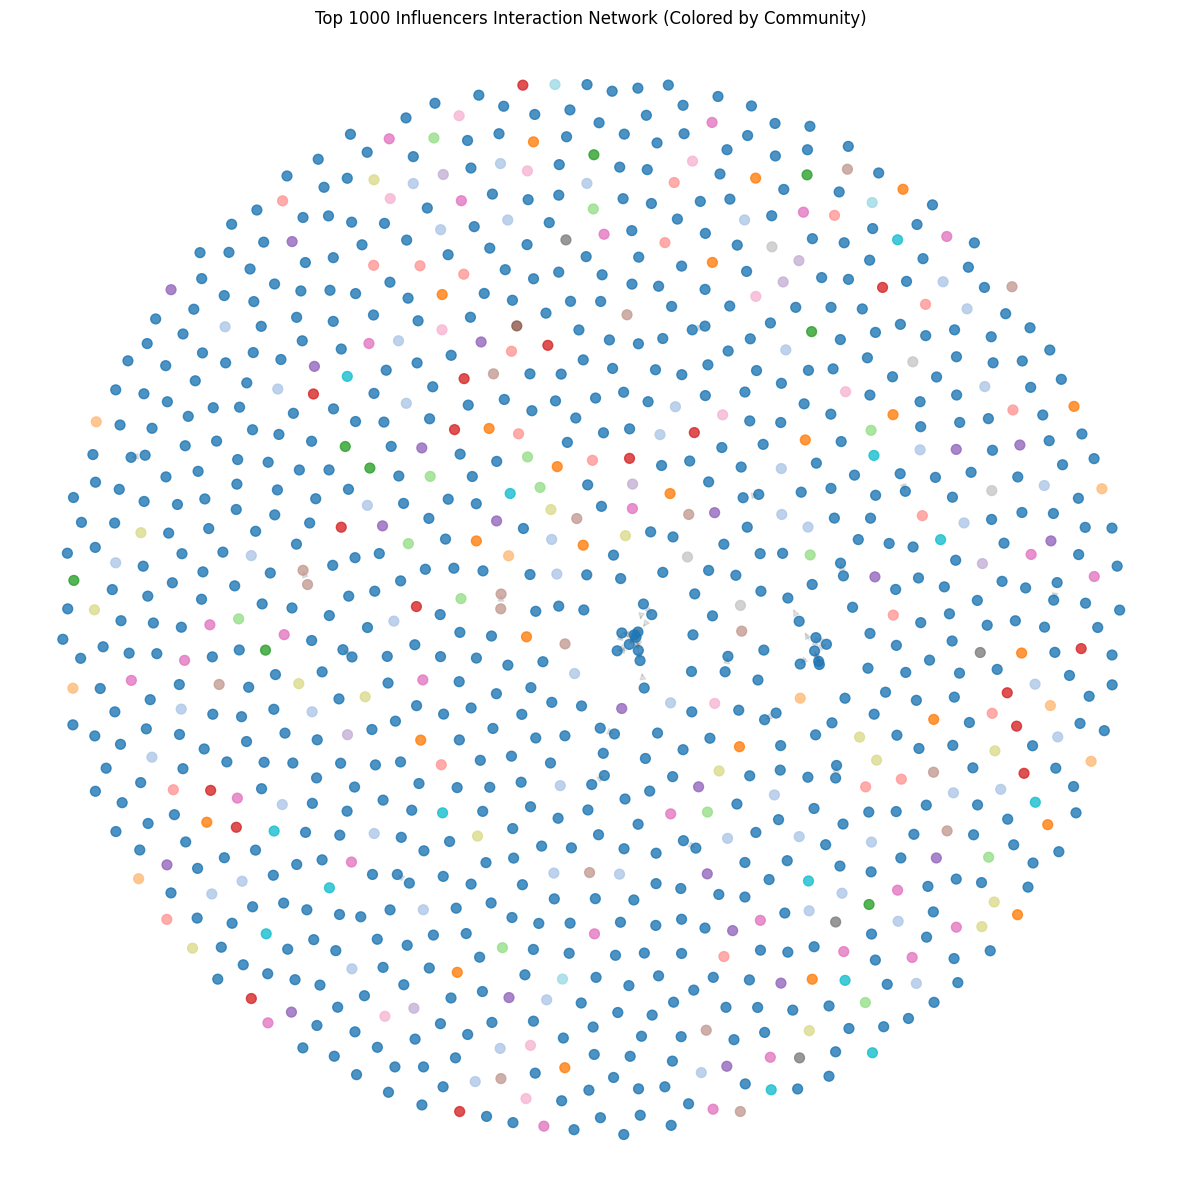

In [7]:
# Convert to undirected for community detection (Louvain usually works on undirected)
G_undirected = G_global.to_undirected()

if len(G_undirected) > 0:
    # Compute partition
    partition = community_louvain.best_partition(G_undirected)
    
    # Add partition info to nodes
    nx.set_node_attributes(G_global, partition, 'community')
    
    # Count communities
    num_communities = len(set(partition.values()))
    print(f"Detected {num_communities} communities.")
    
    # Visualize a manageable subgraph (Top 1000 nodes by PageRank)
    # Visualizing 70k+ nodes will hang the kernel. We focus on the most important nodes.
    print("Filtering graph for visualization (Top 1000 nodes by PageRank)...")
    
    # Get top 1000 nodes
    top_nodes = [n for n, _ in sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:1000]]
    viz_graph = G_global.subgraph(top_nodes)
    
    print(f"Visualizing graph with {len(viz_graph)} nodes...")
    
    plt.figure(figsize=(15, 15))
    # Use a layout that spreads out communities
    pos = nx.spring_layout(viz_graph, k=0.15, seed=42, iterations=50)
    
    # Color by community
    # We might have many communities, so we map them to a colormap
    communities = [partition[n] for n in viz_graph.nodes()]
    
    nx.draw_networkx_nodes(viz_graph, pos, node_color=communities, cmap=plt.get_cmap('tab20'), node_size=50, alpha=0.8)
    nx.draw_networkx_edges(viz_graph, pos, alpha=0.1)
    
    plt.title('Top 1000 Influencers Interaction Network (Colored by Community)')
    plt.axis('off')
    plt.show()

**Graph Explanation:**
This visualization displays the interaction network of the top 1000 influencers, with nodes colored by their detected communities (using the Louvain method). Nodes of the same color belong to the same community, indicating groups of commenters who interact more frequently with each other than with the rest of the network. This helps in identifying distinct sub-groups or niches within the commenter ecosystem.

## 6. Influencer Ranking Visualization

We will visualize the rankings to provide a clear deliverable.

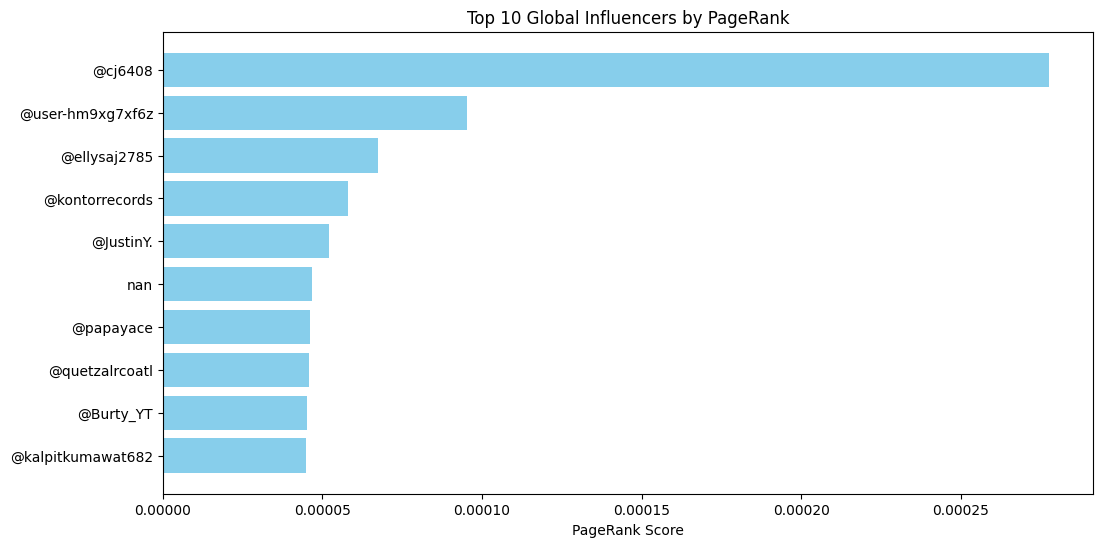

In [8]:
# 6.1 Bar Chart of Top 10 Global Influencers
top_10_names = [str(G_global.nodes[uid].get('name', uid)) for uid, score in top_10_global]
top_10_scores = [score for uid, score in top_10_global]

plt.figure(figsize=(12, 6))
plt.barh(top_10_names[::-1], top_10_scores[::-1], color='skyblue')
plt.xlabel('PageRank Score')
plt.title('Top 10 Global Influencers by PageRank')
plt.show()

**Graph Explanation:**
This bar chart ranks the top 10 global influencers based on their PageRank scores. A higher PageRank score indicates a higher level of influence within the network, meaning these commenters are frequently replied to by other influential users.

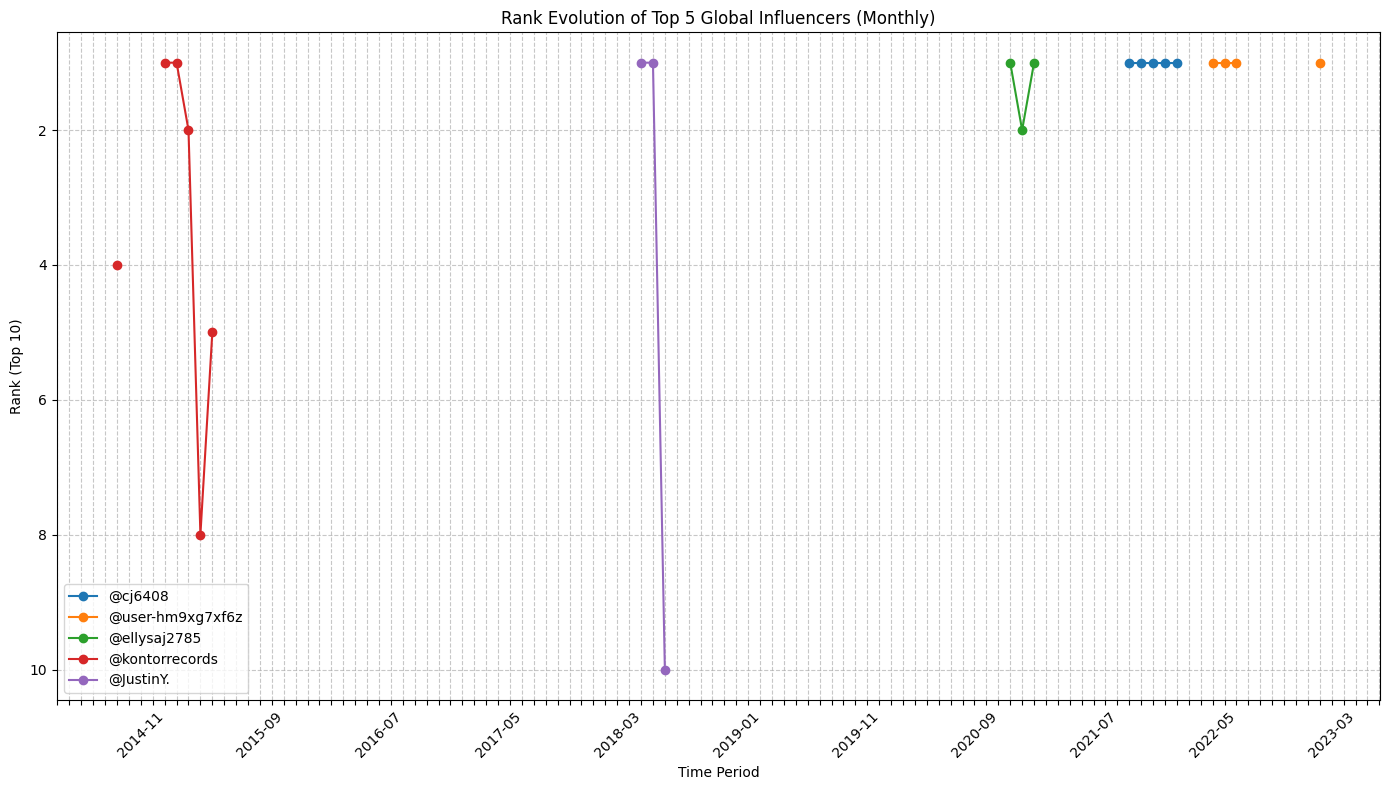

In [9]:
# 6.2 Rank Evolution of Top 5 Global Influencers over Time
# We want to see how the rank of the top 5 global influencers changes across periods

top_5_global_ids = [uid for uid, score in top_10_global[:5]]
top_5_names_map = {uid: str(G_global.nodes[uid].get('name', uid)) for uid in top_5_global_ids}

rank_history = {uid: [] for uid in top_5_global_ids}
periods_list = sorted(period_influencers.keys())
# Convert periods to string for plotting to avoid issues
periods_str = [str(p) for p in periods_list]

for period in periods_list:
    current_top_10_ids = [item['id'] for item in period_influencers[period]]
    
    for uid in top_5_global_ids:
        if uid in current_top_10_ids:
            rank = current_top_10_ids.index(uid) + 1
        else:
            rank = None # Not in top 10
        rank_history[uid].append(rank)

plt.figure(figsize=(14, 8))
for uid in top_5_global_ids:
    plt.plot(periods_str, rank_history[uid], marker='o', label=top_5_names_map[uid])

plt.gca().invert_yaxis() # Rank 1 is higher
plt.ylabel('Rank (Top 10)')
plt.xlabel('Time Period')
plt.title('Rank Evolution of Top 5 Global Influencers (Monthly)')
plt.legend()
plt.xticks(rotation=45)
# Show only every nth label to avoid crowding if many periods
if len(periods_str) > 20:
    ax = plt.gca()
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % (len(periods_str) // 20) != 0:
            label.set_visible(False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Graph Explanation:**
This line chart tracks the rank evolution of the top 5 global influencers over time (monthly periods). It allows us to observe the stability or volatility of their influence. A consistent high rank indicates sustained influence, while fluctuations may suggest viral moments or changing engagement patterns.